In [1]:
import ee
from osgeo import gdal
from osgeo import osr
import pandas as pd
import numpy as np
import time

#from save_gee_image_tiff import save_gee_tiff
ee.Initialize()

In [2]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=30,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):

  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [3]:
#altamira_sul = '-55.39299190419731,-8.72942896034137,-54.71183956044731,-6.999099965455131'
altamira_sul = '-55.3809, -7.5173, -54.714, -8.005'
datas = "2010-01-01,2021-12-31"
inicio,fim = datas.split(",")
x1,y1,x2,y2 = altamira_sul.split(",")
geometria = geometry = ee.Geometry.Polygon(
        [[[float(x1),float(y2)],
          [float(x2),float(y2)],
          [float(x2),float(y1)],
          [float(x1),float(y1)],
          [float(x1),float(y2)]]])

sul_Modis = ee.ImageCollection('MODIS/006/MOD13Q1').filterBounds(geometria).filterDate(inicio,fim).select('NDVI','SummaryQA')
print("Modis: "+str(sul_Modis.size().getInfo()))
def ndvi(imagem):
    ndvi = imagem.expression('(NDVI)/10000',{'NDVI':imagem.select(NDVI)}).rename('ndvi')
    return imagem.addBands(ndvi)
NDVI = 'NDVI'
sul_Modis = sul_Modis.map(ndvi)
listaCN = sul_Modis.toList(sul_Modis.size())

Modis: 276


In [4]:
reduce_ndvi = create_reduce_region_function(
    geometry=geometria, reducer=ee.Reducer.mean(), scale=250)

ndvi_stat_fc = ee.FeatureCollection(sul_Modis.map(reduce_ndvi)).filter(
    ee.Filter.notNull(sul_Modis.first().bandNames()))

ndvi_dict = fc_to_dict(ndvi_stat_fc).getInfo()
ndvi_df = pd.DataFrame(ndvi_dict)
display(ndvi_df)
print(ndvi_df.dtypes)

,NDVI,SummaryQA,millis,ndvi,system:index
0,4400.236331,2.952145,1262304000000,0.440024,2010_01_01
1,6165.428236,2.289908,1263686400000,0.616543,2010_01_17
2,6736.705568,2.014096,1265068800000,0.673671,2010_02_02
3,7567.647789,1.285975,1266451200000,0.756765,2010_02_18
4,7536.951181,1.436591,1267833600000,0.753695,2010_03_06
...,...,...,...,...,...
271,7166.785060,1.741399,1634342400000,0.716679,2021_10_16
272,6665.472091,2.572577,1635724800000,0.666547,2021_11_01
273,7043.303727,2.285268,1637107200000,0.704330,2021_11_17
274,5605.031725,2.862642,1638489600000,0.560503,2021_12_03


NDVI            float64
SummaryQA       float64
millis            int64
ndvi            float64
system:index     object
dtype: object


In [5]:
ndvi_df2 = ndvi_df[ndvi_df['SummaryQA']<1]

In [6]:
ndvi_df2 = add_date_info(ndvi_df2)
ndvi_df2.tail(5)

<ipython-input-2-58732ce07f02>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
<ipython-input-2-58732ce07f02>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
<ipython-input-2-58732ce07f02>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,NDVI,SummaryQA,millis,ndvi,system:index,Timestamp,Year,Month,Day,DOY
264,7571.125462,0.000558,1624665600000,0.757113,2021_06_26,2021-06-26,2021,6,26,177
265,7346.514172,0.000403,1626048000000,0.734651,2021_07_12,2021-07-12,2021,7,12,193
266,7122.253686,0.019390,1627430400000,0.712225,2021_07_28,2021-07-28,2021,7,28,209
267,6716.351986,0.379490,1628812800000,0.671635,2021_08_13,2021-08-13,2021,8,13,225
269,7216.059230,0.774349,1631577600000,0.721606,2021_09_14,2021-09-14,2021,9,14,257


In [7]:
import altair as alt
highlight = alt.selection(
    type='single', on='mouseover', fields=['Year'], nearest=True)

base = alt.Chart(ndvi_df2).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=[0, 353], clamp=True)),
    y=alt.Y('ndvi:Q', scale=alt.Scale(domain=[0, 1])),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')))

points = base.mark_circle().encode(
    opacity=alt.value(0),
    tooltip=[
        alt.Tooltip('Year:O', title='Year'),
        alt.Tooltip('DOY:Q', title='DOY'),
        alt.Tooltip('ndvi:Q', title='NDVI')
    ]).add_selection(highlight)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)))

(points + lines).properties(width=600, height=350).interactive()

alt.LayerChart(...)

In [8]:
base = alt.Chart(ndvi_df2).encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=(0, 360))))

line = base.mark_line().encode(
    y=alt.Y('median(ndvi):Q', scale=alt.Scale(domain=(0, 1))))

band = base.mark_errorband(extent='iqr').encode(
    y='ndvi:Q')

(line + band).properties(width=600, height=300).interactive()

alt.LayerChart(...)

In [9]:
def ext_lat_lon_pixel250(image, geometria, bandas):
    image = image.addBands(ee.Image.pixelLonLat())
    coordenadas = image.select(['longitude', 'latitude']+bandas).reduceRegion(reducer=ee.Reducer.toList(),geometry=geometria,scale=250,bestEffort=True)
    bandas_valores = []
    for banda in bandas:
        bandas_valores.append(np.array(ee.List(coordenadas.get(banda)).getInfo()).astype(float))

    return np.array(ee.List(coordenadas.get('latitude')).getInfo()).astype(float), np.array(ee.List(coordenadas.get('longitude')).getInfo()).astype(float), bandas_valores

In [10]:
indices = ndvi_df2.index.values
lc = ee.List([])
for k in indices:
    imagka = ee.Image(listaCN.get(int(k)))
    lc = lc.add(imagka)

colecao_final = ee.ImageCollection(lc)
img_15 = colecao_final.median().clipToBoundsAndScale(geometry=geometria,scale=500)
print(img_15.select(['ndvi']).getThumbUrl({'min':0, 'max':1}))

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6f034afab80d38fb83e83c0b0cfbe82c-e246b0c1511e65b074b471098be4a83d:getPixels


In [11]:
mediana = colecao_final.median()
lista_sm = ee.List([])
for im in range(colecao_final.size().getInfo()):
    sub_med = ee.Image(lc.get(im)).subtract(mediana)
    lista_sm = lista_sm.add(sub_med)
    
colecao_med = ee.ImageCollection(lista_sm)

In [12]:
defaultDummy = -99999
df_sul = pd.DataFrame()
di = {}
dias = ndvi_df2['Timestamp'].values
for j in range(colecao_med.size().getInfo()):
    tempndvi = dias[j]
    img = ee.Image(defaultDummy).blend(ee.Image(lista_sm.get(j)))
    lat250, lon250, ind250 = ext_lat_lon_pixel250(img,geometria,['ndvi'])
    di[tempndvi] = ind250[0]
    
df_sul = df_sul.from_dict(di)
df_sul = df_sul.assign(Latitude = lat250)
df_sul = df_sul.assign(Longitude = lon250)
df_sul = df_sul.set_index(['Latitude','Longitude'])
df_sul.head()

2010-03-22  2010-04-23  2010-05-09  2010-05-25  \
Latitude  Longitude                                                    
-8.002866 -55.380014    0.001291   -0.034409    0.015891    0.021391   
          -55.377769   -0.023290   -0.027490    0.016510    0.031010   
          -55.375523   -0.026200   -0.030400    0.016600    0.028100   
          -55.373277   -0.044664   -0.027964    0.018236    0.025336   
          -55.371031   -0.023900   -0.021700    0.022200    0.024900   

                      2010-06-10  2010-06-26  2010-07-12  2010-07-28  \
Latitude  Longitude                                                    
-8.002866 -55.380014    0.016391    0.001791    0.005291   -0.000309   
          -55.377769    0.014910   -0.002590   -0.000390    0.000010   
          -55.375523    0.017300    0.000500    0.001900   -0.006900   
          -55.373277    0.021836    0.005436    0.001436    0.006336   
          -55.371031    0.013000   -0.001900    0.000400   -0.007000   

                      2010-09-30  2010-10-16  ...  2020-10-31  2021-03-22  \
Latitude  Longitude                           ...                           
-8.002866 -55.380014   -0.021909   -0.026209  ...   -0.018709   -0.025609   
          -55.377769   -0.021590   -0.023390  ...   -0.018390   -0.020590   
          -55.375523   -0.036200   -0.042700  ...    0.020400   -0.023500   
          -55.373277   -0.030064   -0.037764  ...    0.023336   -0.028064   
          -55.371031   -0.040100   -0.033500  ...   -0.001600   -0.016100   

                      2021-05-09  2021-05-25  2021-06-10  2021-06-26  \
Latitude  Longitude                                                    
-8.002866 -55.380014   -0.019909   -0.031209   -0.035009   -0.017809   
          -55.377769   -0.011090    0.015110   -0.016290   -0.001490   
          -55.375523    0.020800    0.014100   -0.019300   -0.018900   
          -55.373277    0.015236    0.029136   -0.016364   -0.012164   
          -55.371031    0.002300    0.035900   -0.016400    0.012700   

                      2021-07-12  2021-07-28  2021-08-13  2021-09-14  
Latitude  Longitude                                                   
-8.002866 -55.380014   -0.021109   -0.053609   -0.134109   -0.032509  
          -55.377769    0.001310   -0.004290   -0.044090   -0.032190  
          -55.375523    0.007300    0.002400   -0.042600   -0.012200  
          -55.373277    0.012336    0.005336   -0.125464   -0.009664  
          -55.371031    0.013200   -0.000400   -0.028200   -0.017500  

[5 rows x 134 columns]

### Isolation Forest

In [13]:
oc_val = df_sul.values.reshape(-1,1)
oc_val = np.delete(oc_val, np.where(oc_val == defaultDummy))
dpoc = np.std(oc_val)
meanoc = np.mean(oc_val)
print(dpoc, meanoc)
listareg = []
alpha = 1 #float(input('digite o valor de alpha: '))
inf_lim = meanoc - alpha*dpoc
sup_lim = meanoc + alpha*dpoc
for i in oc_val:
    if inf_lim < i < sup_lim:
        listareg.append(i)
        
array_reg = np.asarray(listareg)
len(array_reg)

0.08526865879710195 -0.015061260466462334


6944848

In [14]:
pd.options.mode.chained_assignment = None
import sklearn
from sklearn.ensemble import IsolationForest
#treino = df_sul.values.reshape(-1,1)
#classificador = IsolationForest(n_estimators=40,random_state=0,max_samples='auto').fit(treino)

In [19]:
def transitions(df):
    diff = df + df.shift(1)
    zero = (diff == 0).astype(int).sum()
    return zero

def mantem_normal(df):
    soma = df + df.shift(1)
    dois = (soma == 2).astype(int).sum()
    return dois

def mantem_anomalia(df):
    soma = df + df.shift(1)
    dois = (soma == -2).astype(int).sum()
    return dois

def contador_reg(df):
    return (df == 1).astype(int).sum()

def contador_anomaly(df):
    return (df == -1).astype(int).sum()

from scipy import stats
from statistics import NormalDist
def p_valor(df):
    return 1 - NormalDist().cdf(df)

In [20]:
def isola2(df, classificador):
    x = df.to_numpy().reshape(-1,1)
    res2 = classificador.predict(x)
    #res = np.where(res2 < 0, abs(res2), 0)
    ser = pd.Series(res2, index=df.index)
    return ser

def cria_dataf(x, classificador):
    tab_ex = pd.DataFrame(index=x.index, columns= x.columns)

    for i in range(x.shape[1]):
        vals = isola2(x.iloc[:,i], classificador)
        tab_ex.iloc[:,i] = vals  
    return tab_ex

def Aplica_Metricas(x):
    tabela_de_testes = x
    tab_stats_oc = pd.DataFrame()
    tab_stats_oc.loc[:,'Anomalias'] = tabela_de_testes.apply(contador_anomaly, axis=1)
    tab_stats_oc.loc[:,'Regular'] = tabela_de_testes.apply(contador_reg, axis=1)
    tab_stats_oc.loc[:,'Mudanças'] = tabela_de_testes.apply(transitions, axis=1)
    tab_stats_oc.loc[:,'Permanece Regular'] = tabela_de_testes.apply(mantem_normal, axis=1)
    tab_stats_oc.loc[:,'Permanece Anomalia'] = tabela_de_testes.apply(mantem_anomalia, axis=1)
    ano = tab_stats_oc['Anomalias']; reg = tab_stats_oc['Regular']; mud = tab_stats_oc['Mudanças']
    media = np.mean(mud)
    stdev = np.std(mud)
    tab_stats_oc.loc[:,'media'] = media
    tab_stats_oc.loc[:,'std'] = stdev
    tab_stats_oc.loc[:,'z'] = (mud - media)/stdev
    tab_stats_oc.loc[:,'p-valor'] = tab_stats_oc.loc[:,'z'].apply(p_valor)
    return tab_stats_oc

In [16]:
def save_tiff_fromdf(df,bands,dummy,path_out):
    
    lat = []
    lon = []
    for i in range(len(df)):
        lat.append(df.index[i][0])
        lon.append(df.index[i][1])
    
    
    ulat = np.unique(lat)
    ulon = np.unique(lon)
    ncols = len(ulon)
    nrows = len(ulat)
    nbands = len(bands)
    ys = ulat[11]-ulat[10]
    xs = ulon[11]-ulon[10]
    
    arr = np.zeros([nbands, nrows, ncols], np.float32)
    refLat = np.max(ulat)
    refLon = np.min(ulon)
    for j in range(len(df)):
        posLin = np.int64( np.round( (refLat - lat[j])/ys ) )
        posCol = np.int64( np.round( (lon[j] - refLon)/xs ) )
        for b in range(nbands):
            arr[b,posLin,posCol] = df.loc[df.index[j],bands[b]]
            
    transform = (np.min(ulon),xs,0,np.max(ulat),0,-ys)
    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)
    
    driver = gdal.GetDriverByName('GTiff')
    outDs = driver.Create(path_out,ncols,nrows,nbands,gdal.GDT_Float32)
    outDs.SetGeoTransform(transform)
    outDs.SetProjection(target.ExportToWkt())

    ind = 1
    for b in range(nbands):
        bandArr = np.copy(arr[b,:,:])
        outBand = outDs.GetRasterBand(ind)
        outBand.WriteArray(bandArr)
        outBand.FlushCache()
        outBand.SetNoDataValue(dummy)
        ind += 1

    outDs = None
    del outDs, outBand

    return 'ok...'

In [21]:
data_dict_if = {}
metric_dict_if = {}
bands = ['Anomalias','p-valor']
defaultDummy = -99999
for i in range(5):
    valor = 20+ 20*i 
    texto = str(valor) + '_Estimators'
    classi = IsolationForest(n_estimators=valor,n_jobs=-1).fit(array_reg.reshape(-1,1))
    tab_ex = cria_dataf(df_sul, classi)
    data_dict_if[texto] = tab_ex
    tab_res = Aplica_Metricas(tab_ex)
    metric_dict_if[texto] = tab_res
    path_out = 'Tiff/V3/IF/Altamira_NDVI_IF_' + texto + '.tif'
    save_tiff_fromdf(tab_res,bands,defaultDummy,path_out)
    print(i)

0
1
2
3
4


In [29]:
import datetime
from datetime import date

vetordate = data_dict_if['20_Estimators'].columns.to_series().dt.year.unique()
cont = 1
aux = 0
fim = vetordate[2]
col_dt_anom = {}
while (2*cont + aux) <= len(vetordate):
    x = 2*cont + aux
    fim = vetordate[x]
    comeco = vetordate[x-2]
    cont += 1
    aux += 1
    elemento = datetime.datetime.strptime(str(fim),"%Y")
    elemento1 = datetime.datetime.strptime(str(comeco),"%Y")
    limite_sup = date(elemento.year, 12, 31)
    limite_inf = date(elemento1.year, 1, 1)
    print(limite_inf, limite_sup)
    filtered = data_dict_if['20_Estimators'].loc[:,(data_dict_if['20_Estimators'].columns <= elemento)&(data_dict_if['20_Estimators'].columns >= elemento1)]
    name = str(comeco) + "-" + str(fim)
    col_dt_anom[name] = filtered
    print('ok')

2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok


In [30]:
def apply_stats(tabela_de_testes):
    tab_stats_oc = pd.DataFrame()
    tab_stats_oc.loc[:,'Anomalias'] = tabela_de_testes.apply(contador_anomaly, axis=1)
    tab_stats_oc.loc[:,'Regular'] = tabela_de_testes.apply(contador_reg, axis=1)
    tab_stats_oc.loc[:,'Mudanças'] = tabela_de_testes.apply(transitions, axis=1)
    tab_stats_oc.loc[:,'Permanece Regular'] = tabela_de_testes.apply(mantem_normal, axis=1)
    tab_stats_oc.loc[:,'Permanece Anomalia'] = tabela_de_testes.apply(mantem_anomalia, axis=1)
    ano = tab_stats_oc['Anomalias']; reg = tab_stats_oc['Regular']; mud = tab_stats_oc['Mudanças']
    media = np.mean(mud)
    stdev = np.std(mud)
    tab_stats_oc.loc[:,'media'] = media
    tab_stats_oc.loc[:,'std'] = stdev
    tab_stats_oc.loc[:,'z'] = (mud - media)/stdev
    tab_stats_oc.loc[:,'p-valor'] = tab_stats_oc.loc[:,'z'].apply(p_valor)
    return tab_stats_oc

def monta_dict_anomaly(tab_testes):
    vetordate = tab_testes.columns.to_series().dt.year.unique()
    cont = 1
    aux = 0
    fim = vetordate[2]
    col_dt_anom = {}
    while (2*cont + aux) <= len(vetordate):
        x = 2*cont + aux
        fim = vetordate[x]
        comeco = vetordate[x-2]
        cont += 1
        aux += 1
        elemento = datetime.datetime.strptime(str(fim),"%Y")
        elemento1 = datetime.datetime.strptime(str(comeco),"%Y")
        limite_sup = date(elemento.year, 12, 31)
        limite_inf = date(elemento1.year, 1, 1)
        print(limite_inf, limite_sup)
        filtered = tab_testes.loc[:,(tab_testes.columns <= elemento)&(tab_testes.columns >= elemento1)]
        name = str(comeco) + "-" + str(fim)
        col_dt_anom[name] = filtered
        print('ok')
    return col_dt_anom

In [33]:
chave = list(data_dict_if.keys())
bands = ['Anomalias','p-valor']
for i in chave:
    yxz = apply_stats(data_dict_if[i])
    path_out = 'Tiff/V3/IF/Valida/Alt_if_modis_' + str(i) + '.tif'
    save_tiff_fromdf(yxz,bands,defaultDummy,path_out)

In [34]:
bands = ['Anomalias','p-valor']
for i in chave:
    w = monta_dict_anomaly(data_dict_if[i])
    for k in w.keys():
        yxz = apply_stats(w[k])
        path_out = 'Tiff/V3/IF/Valida/Alt_if_modis_' + str(i) + "_" + str(k) + '.tif'
        save_tiff_fromdf(yxz,bands,defaultDummy,path_out)

2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok
2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok
2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok
2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok
2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok


### One-Class SVM

In [41]:
def save_tiff_fromdf(df,bands,dummy,path_out):
    
    lat = []
    lon = []
    for i in range(len(df)):
        lat.append(df.index[i][0])
        lon.append(df.index[i][1])
    
    
    ulat = np.unique(lat)
    ulon = np.unique(lon)
    ncols = len(ulon)
    nrows = len(ulat)
    nbands = len(bands)
    ys = ulat[11]-ulat[10]
    xs = ulon[11]-ulon[10]
    
    arr = np.zeros([nbands, nrows, ncols], np.float32)
    refLat = np.max(ulat)
    refLon = np.min(ulon)
    for j in range(len(df)):
        posLin = np.int64( np.round( (refLat - lat[j])/ys ) )
        posCol = np.int64( np.round( (lon[j] - refLon)/xs ) )
        for b in range(nbands):
            arr[b,posLin,posCol] = df.loc[df.index[j],bands[b]]
            
    transform = (np.min(ulon),xs,0,np.max(ulat),0,-ys)
    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)
    
    driver = gdal.GetDriverByName('GTiff')
    outDs = driver.Create(path_out,ncols,nrows,nbands,gdal.GDT_Float32)
    outDs.SetGeoTransform(transform)
    outDs.SetProjection(target.ExportToWkt())

    ind = 1
    for b in range(nbands):
        bandArr = np.copy(arr[b,:,:])
        outBand = outDs.GetRasterBand(ind)
        outBand.WriteArray(bandArr)
        outBand.FlushCache()
        outBand.SetNoDataValue(dummy)
        ind += 1

    outDs = None
    del outDs, outBand

    return 'ok...'

In [34]:
oc_val = df_sul.values.reshape(-1,1)
oc_val = np.delete(oc_val, np.where(oc_val == defaultDummy))
dpoc = np.std(oc_val)
meanoc = np.mean(oc_val)
print(dpoc, meanoc)
listareg = []
alpha = 0.5 #float(input('digite o valor de alpha: '))
inf_lim = meanoc - alpha*dpoc
sup_lim = meanoc + alpha*dpoc
for i in oc_val:
    if inf_lim < i < sup_lim:
        listareg.append(i)
        
array_reg = np.asarray(listareg)
len(array_reg)

0.08526865879710195 -0.015061260466462334


5537184

In [37]:
beta = 0.005 #float(input('digite o valor de beta: '))
novo_data = int(beta * len(array_reg))
dataind = np.random.choice(len(array_reg),size=novo_data)
dataset = array_reg[dataind]
len(dataset)

27685

In [39]:
pd.options.mode.chained_assignment = None
import sklearn
from sklearn.svm import OneClassSVM

occlf = OneClassSVM(nu=0.05).fit(dataset.reshape(-1,1))

def OCSVM(df):
    y = df.to_numpy().reshape(-1,1)
    res = occlf.predict(y)
    ser = pd.Series(res, index=df.index)
    return ser

In [56]:
def isola2(df, classificador):
    x = df.to_numpy().reshape(-1,1)
    res2 = classificador.predict(x)
    #res = np.where(res2 < 0, abs(res2), 0)
    ser = pd.Series(res2, index=df.index)
    return ser

def cria_dataf(x, classificador):
    tab_ex = pd.DataFrame(index=x.index, columns= x.columns)

    for i in range(x.shape[1]):
        vals = isola2(x.iloc[:,i], classificador)
        tab_ex.iloc[:,i] = vals  
    return tab_ex

In [47]:
def Aplica_Metricas(x):
    tabela_de_testes = x
    tab_stats_oc = pd.DataFrame()
    tab_stats_oc.loc[:,'Anomalias'] = tabela_de_testes.apply(contador_anomaly, axis=1)
    tab_stats_oc.loc[:,'Regular'] = tabela_de_testes.apply(contador_reg, axis=1)
    tab_stats_oc.loc[:,'Mudanças'] = tabela_de_testes.apply(transitions, axis=1)
    tab_stats_oc.loc[:,'Permanece Regular'] = tabela_de_testes.apply(mantem_normal, axis=1)
    tab_stats_oc.loc[:,'Permanece Anomalia'] = tabela_de_testes.apply(mantem_anomalia, axis=1)
    ano = tab_stats_oc['Anomalias']; reg = tab_stats_oc['Regular']; mud = tab_stats_oc['Mudanças']
    media = np.mean(mud)
    stdev = np.std(mud)
    tab_stats_oc.loc[:,'media'] = media
    tab_stats_oc.loc[:,'std'] = stdev
    tab_stats_oc.loc[:,'z'] = (mud - media)/stdev
    tab_stats_oc.loc[:,'p-valor'] = tab_stats_oc.loc[:,'z'].apply(p_valor)
    return tab_stats_oc

In [45]:
def transitions(df):
    diff = df + df.shift(1)
    zero = (diff == 0).astype(int).sum()
    return zero

def mantem_normal(df):
    soma = df + df.shift(1)
    dois = (soma == 2).astype(int).sum()
    return dois

def mantem_anomalia(df):
    soma = df + df.shift(1)
    dois = (soma == -2).astype(int).sum()
    return dois

def contador_reg(df):
    return (df == 1).astype(int).sum()

def contador_anomaly(df):
    return (df == -1).astype(int).sum()

from scipy import stats
from statistics import NormalDist
def p_valor(df):
    return 1 - NormalDist().cdf(df)

In [57]:
nuu = [0.025, 0.05, 0.1]
data_dict_oc = {}
metric_dict = {}
bands = ['Anomalias','p-valor']
for i in nuu:
    classi = OneClassSVM(nu=i, kernel='rbf', gamma='auto').fit(dataset.reshape(-1,1))
    tab_ex = cria_dataf(df_sul, classi)
    data_dict_oc[i] = tab_ex
    tab_res = Aplica_Metricas(tab_ex)
    metric_dict[i] = tab_res
    path_out = 'Tiff/V3/Altamira_NDVI_OCSVM_' + str(i) + '.tif'
    save_tiff_fromdf(tab_res,bands,defaultDummy,path_out)
    print(i)

0.025
0.05
0.1


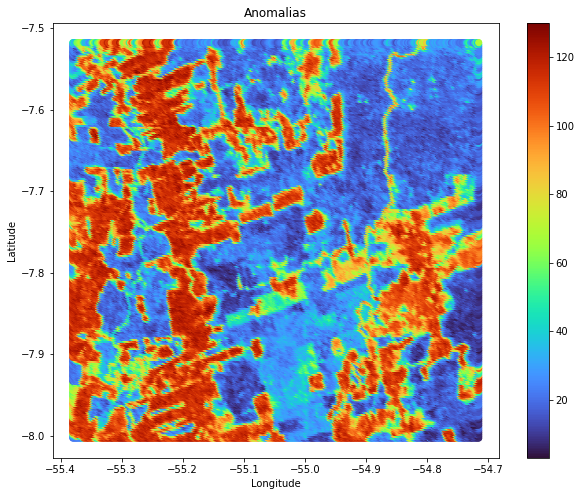

In [64]:
import matplotlib.pyplot as plt
mask1 = tab_res['Anomalias'].values
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x,y,c=mask1,cmap='turbo')
ax.set_title('Anomalias')
plt.colorbar(ax.scatter(x,y,c=mask1,cmap='turbo'),ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Mari30_NDVI_OC_anom.png')
plt.show()

### Analysis per year

In [65]:
import time
import datetime

elemento = datetime.datetime.strptime("2016","%Y")
elemento1 = datetime.datetime.strptime("2013","%Y")

In [67]:
data_dict_oc[0.025]

2010-03-22  2010-04-23  2010-05-09  2010-05-25  \
Latitude  Longitude                                                    
-8.002866 -55.380014           1           1           1           1   
          -55.377769           1           1           1          -1   
          -55.375523           1           1           1          -1   
          -55.373277           1           1           1           1   
          -55.371031           1           1           1           1   
...                          ...         ...         ...         ...   
-7.517776 -54.724244          -1           1           1           1   
          -54.721998          -1           1          -1           1   
          -54.719753          -1          -1          -1           1   
          -54.717507          -1           1           1           1   
          -54.715261          -1           1           1           1   

                      2010-06-10  2010-06-26  2010-07-12  2010-07-28  \
Latitude  Longitude                                                    
-8.002866 -55.380014           1           1           1           1   
          -55.377769           1           1           1           1   
          -55.375523           1           1           1           1   
          -55.373277           1           1           1           1   
          -55.371031           1           1           1           1   
...                          ...         ...         ...         ...   
-7.517776 -54.724244           1           1           1           1   
          -54.721998           1           1           1           1   
          -54.719753           1           1          -1           1   
          -54.717507           1           1           1           1   
          -54.715261           1           1          -1          -1   

                      2010-09-30  2010-10-16  ...  2020-10-31  2021-03-22  \
Latitude  Longitude                           ...                           
-8.002866 -55.380014           1           1  ...           1           1   
          -55.377769           1           1  ...           1           1   
          -55.375523           1           1  ...           1           1   
          -55.373277           1           1  ...           1           1   
          -55.371031           1           1  ...           1           1   
...                          ...         ...  ...         ...         ...   
-7.517776 -54.724244           1           1  ...           1           1   
          -54.721998           1           1  ...           1           1   
          -54.719753          -1          -1  ...           1           1   
          -54.717507           1          -1  ...           1           1   
          -54.715261          -1          -1  ...          -1           1   

                      2021-05-09  2021-05-25  2021-06-10  2021-06-26  \
Latitude  Longitude                                                    
-8.002866 -55.380014           1           1           1           1   
          -55.377769           1           1           1           1   
          -55.375523           1           1           1           1   
          -55.373277           1          -1           1           1   
          -55.371031           1          -1           1           1   
...                          ...         ...         ...         ...   
-7.517776 -54.724244           1           1           1           1   
          -54.721998           1           1           1           1   
          -54.719753           1          -1          -1           1   
          -54.717507           1           1           1          -1   
          -54.715261          -1          -1          -1           1   

                      2021-07-12  2021-07-28  2021-08-13  2021-09-14  
Latitude  Longitude                                                   
-8.002866 -55.380014           1           1          -1           

In [68]:
data_dict_oc[0.025].columns.to_series().dt.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021], dtype=int64)

In [70]:
from datetime import date

In [72]:
vetordate = data_dict_oc[0.025].columns.to_series().dt.year.unique()
cont = 1
aux = 0
fim = vetordate[2]
col_dt_anom = {}
while (2*cont + aux) <= len(vetordate):
    x = 2*cont + aux
    fim = vetordate[x]
    comeco = vetordate[x-2]
    cont += 1
    aux += 1
    elemento = datetime.datetime.strptime(str(fim),"%Y")
    elemento1 = datetime.datetime.strptime(str(comeco),"%Y")
    limite_sup = date(elemento.year, 12, 31)
    limite_inf = date(elemento1.year, 1, 1)
    print(limite_inf, limite_sup)
    filtered = data_dict_oc[0.025].loc[:,(data_dict_oc[0.025].columns <= elemento)&(data_dict_oc[0.025].columns >= elemento1)]
    name = str(comeco) + "-" + str(fim)
    col_dt_anom[name] = filtered
    print('ok')

2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok


In [73]:
chave = list(data_dict_oc.keys())

In [74]:
def apply_stats(tabela_de_testes):
    tab_stats_oc = pd.DataFrame()
    tab_stats_oc.loc[:,'Anomalias'] = tabela_de_testes.apply(contador_anomaly, axis=1)
    tab_stats_oc.loc[:,'Regular'] = tabela_de_testes.apply(contador_reg, axis=1)
    tab_stats_oc.loc[:,'Mudanças'] = tabela_de_testes.apply(transitions, axis=1)
    tab_stats_oc.loc[:,'Permanece Regular'] = tabela_de_testes.apply(mantem_normal, axis=1)
    tab_stats_oc.loc[:,'Permanece Anomalia'] = tabela_de_testes.apply(mantem_anomalia, axis=1)
    ano = tab_stats_oc['Anomalias']; reg = tab_stats_oc['Regular']; mud = tab_stats_oc['Mudanças']
    media = np.mean(mud)
    stdev = np.std(mud)
    tab_stats_oc.loc[:,'media'] = media
    tab_stats_oc.loc[:,'std'] = stdev
    tab_stats_oc.loc[:,'z'] = (mud - media)/stdev
    tab_stats_oc.loc[:,'p-valor'] = tab_stats_oc.loc[:,'z'].apply(p_valor)
    return tab_stats_oc

In [75]:
def monta_dict_anomaly(tab_testes):
    vetordate = tab_testes.columns.to_series().dt.year.unique()
    cont = 1
    aux = 0
    fim = vetordate[2]
    col_dt_anom = {}
    while (2*cont + aux) <= len(vetordate):
        x = 2*cont + aux
        fim = vetordate[x]
        comeco = vetordate[x-2]
        cont += 1
        aux += 1
        elemento = datetime.datetime.strptime(str(fim),"%Y")
        elemento1 = datetime.datetime.strptime(str(comeco),"%Y")
        limite_sup = date(elemento.year, 12, 31)
        limite_inf = date(elemento1.year, 1, 1)
        print(limite_inf, limite_sup)
        filtered = tab_testes.loc[:,(tab_testes.columns <= elemento)&(tab_testes.columns >= elemento1)]
        name = str(comeco) + "-" + str(fim)
        col_dt_anom[name] = filtered
        print('ok')
    return col_dt_anom

In [76]:
## One-Class SVM
bands = ['Anomalias','p-valor']
for i in chave:
    yxz = apply_stats(data_dict_oc[i])
    path_out = 'Tiff/V3//Alt_OCSVM_modis_' + str(i) + '.tif'
    save_tiff_fromdf(yxz,bands,defaultDummy,path_out)

In [126]:
cole_dt_anom_IF = monta_dict_anomaly(tabela_de_testes)
cole_dt_anom_IF

2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok


{'2010-2012':                      2010-04-23 2010-05-09 2010-05-25 2010-06-10 2010-06-26  \
 Latitude  Longitude                                                           
 -8.728256 -55.391243          1          1          1          1          1   
           -55.388998          1          1          1          1          1   
           -55.386752          1          1          1          1          1   
           -55.384506          1          1          1          1          1   
           -55.382260          1          1          1          1          1   
 ...                         ...        ...        ...        ...        ...   
 -7.001245 -54.721998          1          1          1          1          1   
           -54.719753         -1          1          1          1          1   
           -54.717507          1          1          1          1          1   
           -54.715261          1          1          1          1          1   
           -54.713015      

In [88]:
bands = ['Anomalias','p-valor']
for i in chave:
    w = monta_dict_anomaly(data_dict_oc[i])
    for k in w.keys():
        yxz = apply_stats(w[k])
        path_out = 'Tiff/V3//Alt_OCSVM_nu_' + str(i) + "_" + str(k) + '.tif'
        save_tiff_fromdf(yxz,bands,defaultDummy,path_out)

2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok
2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok
2010-01-01 2012-12-31
ok
2013-01-01 2015-12-31
ok
2016-01-01 2018-12-31
ok
2019-01-01 2021-12-31
ok


## Reference date validation

In [79]:
datadia = '2020-07-26'
ref_date = datetime.datetime.strptime(datadia, "%Y-%m-%d")

res = min(data_dict_oc[0.025].columns, key=lambda sub: abs(sub - ref_date))
res

Timestamp('2020-07-27 00:00:00')

In [81]:
type(res) == type(data_dict_oc[0.025].columns[0])

True

In [82]:
str(res)[:10]

'2020-07-27'

In [155]:
for i in chave:
    for item in data_dict_oc[i].columns:
        if res == item:
            print(str(item)[:10])
            downdata_if = data_dict_oc[i].loc[:,:item]
            path_out = 'Tiff/V3//Alt_OCSVM_modis_' + str(item)[:10] + '.tif'
            save_tiff_fromdf(downdata_if,[item],defaultDummy,path_out)
            #downdata_oc = tabela_de_testes.loc[:,:item]
            #path_out = 'Tiff/Alt_OCSVM_modis_' + str(item)[:10] + '.tif'
            #save_tiff_fromdf(downdata_oc,[item],defaultDummy,path_out)

2020-07-27


In [ ]:
data_dict_oc[0.025].loc[:]

In [83]:
col_dt_anom

{'2010-2012':                       2010-03-22  2010-04-23  2010-05-09  2010-05-25  \
 Latitude  Longitude                                                    
 -8.002866 -55.380014           1           1           1           1   
           -55.377769           1           1           1          -1   
           -55.375523           1           1           1          -1   
           -55.373277           1           1           1           1   
           -55.371031           1           1           1           1   
 ...                          ...         ...         ...         ...   
 -7.517776 -54.724244          -1           1           1           1   
           -54.721998          -1           1          -1           1   
           -54.719753          -1          -1          -1           1   
           -54.717507          -1           1           1           1   
           -54.715261          -1           1           1           1   
 
                       2010-06-10  2